# Project Inquiries:

1) Is the Earth’s temperature rising over time?

2) Does Earth’s temperature fluctuate in a predictable pattern?

3) Can we use readings of past Earth temperatures to predict future Earth temperatures?

4) Does taking the average temperature over land very in pattern, predictability, or variability from temperature taken over land and ocean?

In [1]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [4]:
df.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


### Convert dataframe to datatime

In [5]:
# Reassign the sale_date column to be a datetime type
df.dt = pd.to_datetime(df.dt)

# Sort rows by the date and then set the index as that date
df = df.set_index("dt").sort_index()

df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


### Break off land temperarure and land and ocean temperarure into seperate dataframes

In [6]:
df_land = df[["LandAverageTemperature"]]
df_land.head()

,LandAverageTemperature
dt,
1750-01-01,3.034
1750-02-01,3.083
1750-03-01,5.626
1750-04-01,8.490
1750-05-01,11.573


In [7]:
df_lo = df[["LandAndOceanAverageTemperature"]]
df_lo.head()

,LandAndOceanAverageTemperature
dt,
1750-01-01,NaN
1750-02-01,NaN
1750-03-01,NaN
1750-04-01,NaN
1750-05-01,NaN


### remove rows before land and ocean data was taken from the land and ocean dataframe

In [8]:
df_lo = df_lo.loc[df.index >= '1850-01-01']
df_lo.head()

,LandAndOceanAverageTemperature
dt,
1850-01-01,12.833
1850-02-01,13.588
1850-03-01,14.043
1850-04-01,14.667
1850-05-01,15.507


### convert temperature from celsius to fahrenheit

In [9]:
def cel_to_fah(value):
    
    return (value*2) + 30

In [10]:
df_land = df_land.apply(cel_to_fah)
df_lo = df_lo.apply(cel_to_fah)

In [11]:
df_land.head()

,LandAverageTemperature
dt,
1750-01-01,36.068
1750-02-01,36.166
1750-03-01,41.252
1750-04-01,46.980
1750-05-01,53.146


In [12]:
df_land.tail()

,LandAverageTemperature
dt,
2015-08-01,59.510
2015-09-01,55.998
2015-10-01,51.602
2015-11-01,44.866
2015-12-01,41.036


In [13]:
df_lo.head()

,LandAndOceanAverageTemperature
dt,
1850-01-01,55.666
1850-02-01,57.176
1850-03-01,58.086
1850-04-01,59.334
1850-05-01,61.014


In [14]:
df_lo.tail()

,LandAndOceanAverageTemperature
dt,
2015-08-01,65.178
2015-09-01,64.098
2015-10-01,62.580
2015-11-01,60.504
2015-12-01,59.548


### Look for nulls

In [15]:
df_land.isnull().sum()

LandAverageTemperature    12
dtype: int64

In [16]:
df_land_nulls = df_land[df_land.LandAverageTemperature.isnull()]
df_land_nulls

,LandAverageTemperature
dt,
1750-11-01,NaN
1751-05-01,NaN
1751-07-01,NaN
1751-10-01,NaN
1751-11-01,NaN
1751-12-01,NaN
1752-02-01,NaN
1752-05-01,NaN
1752-06-01,NaN


In [17]:
df_land.head(30)

,LandAverageTemperature
dt,
1750-01-01,36.068
1750-02-01,36.166
1750-03-01,41.252
1750-04-01,46.980
1750-05-01,53.146
1750-06-01,55.874
1750-07-01,61.736
1750-08-01,59.500
1750-09-01,52.826


In [18]:
df_lo.isnull().sum()

LandAndOceanAverageTemperature    0
dtype: int64

### remove data up to 1752-09-01 from the land only temperature dataframe to eliminate nulls from the dataframe

In [19]:
df_land = df_land.loc[df.index > '1752-09-01']
df_land.isnull().sum()

LandAverageTemperature    0
dtype: int64

### split into test train using 80% train 20% test

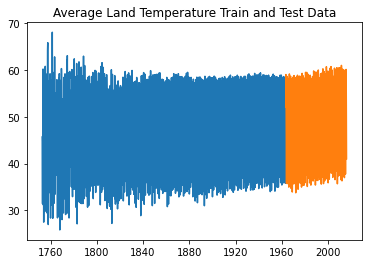

In [20]:
train_size = .80
n = df_land.shape[0]
test_start_index = round(train_size * n)

train_land = df_land[:test_start_index] 
test_land = df_land[test_start_index:] 

plt.title("Average Land Temperature Train and Test Data")
plt.plot(train_land.index, train_land.LandAverageTemperature)
plt.plot(test_land.index, test_land.LandAverageTemperature)

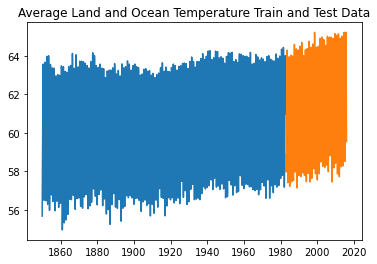

In [21]:
train_size = .80
n = df_lo.shape[0]
test_start_index = round(train_size * n)

train_ocean = df_lo[:test_start_index]
test_ocean = df_lo[test_start_index:]

plt.title("Average Land and Ocean Temperature Train and Test Data")
plt.plot(train_ocean.index, train_ocean.LandAndOceanAverageTemperature)
plt.plot(test_ocean.index, test_ocean.LandAndOceanAverageTemperature)

# Exploration

View each temperature line next to the other, resample using the average temperature by year, and by decade.

In [22]:
train_land.describe()

,LandAverageTemperature
count,2527.000000
mean,46.402163
std,8.831321
min,25.840000
25%,38.158000
50%,46.786000
75%,54.647000
max,68.042000


In [23]:
train_ocean.describe()

,LandAndOceanAverageTemperature
count,1594.000000
mean,60.198164
std,2.518792
min,54.950000
25%,57.828000
50%,60.324000
75%,62.586000
max,64.434000


<function matplotlib.pyplot.show(close=None, block=None)>

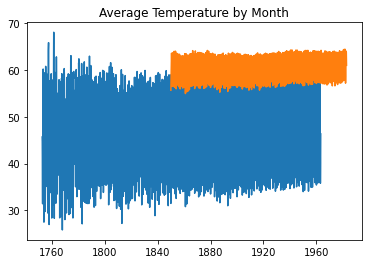

In [24]:
plt.title("Average Temperature by Month")
plt.plot(train_land)
plt.plot(train_ocean)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

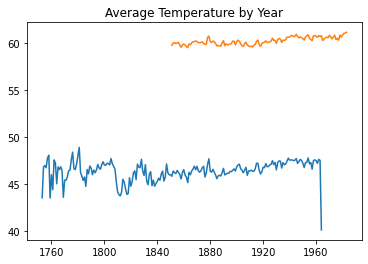

In [25]:
plt.title("Average Temperature by Year")
plt.plot(train_land.resample('y').mean())
plt.plot(train_ocean.resample('y').mean())
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

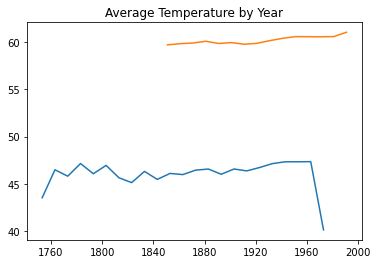

In [26]:
plt.title("Average Temperature by Year")
plt.plot(train_land.resample('10y').mean())
plt.plot(train_ocean.resample('10y').mean())
plt.show

Observation 1: land only temperature varies much more than land and ocean temperature.

Observation 2: land only temperature’s variance lessons over time this could be accounted for by technological advancements lessoning the error over time. 

Next step compare the two using only dates where both observations exist in the training data.